In [1]:
import os
import cv2
import IPython
from datetime import datetime
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow.python import keras

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

In [3]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [4]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    x=x_train, y=y_train, epochs=5
)

Epoch 1/5
60000/60000 [==============================] - 42s 705us/sample - loss: 0.1447 - accuracy: 0.9555
Epoch 2/5
60000/60000 [==============================] - 39s 644us/sample - loss: 0.0474 - accuracy: 0.9852
Epoch 3/5
60000/60000 [==============================] - 38s 641us/sample - loss: 0.0342 - accuracy: 0.9893
Epoch 4/5
60000/60000 [==============================] - 39s 647us/sample - loss: 0.0266 - accuracy: 0.9912
Epoch 5/5
60000/60000 [==============================] - 39s 647us/sample - loss: 0.0203 - accuracy: 0.9935


In [5]:
y_pred = model.predict_classes(x=x_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[
    '%d' % i for i in range(10)
], digits=5))

Test Accuracy:  0.9919
              precision    recall  f1-score   support

           0    0.99490   0.99490   0.99490       980
           1    0.99559   0.99559   0.99559      1135
           2    0.98751   0.99612   0.99180      1032
           3    0.99211   0.99604   0.99407      1010
           4    0.99390   0.99491   0.99440       982
           5    0.98224   0.99215   0.98717       892
           6    0.99267   0.98956   0.99111       958
           7    0.99023   0.98638   0.98830      1028
           8    0.99485   0.99076   0.99280       974
           9    0.99398   0.98216   0.98804      1009

   micro avg    0.99190   0.99190   0.99190     10000
   macro avg    0.99180   0.99186   0.99182     10000
weighted avg    0.99192   0.99190   0.99190     10000



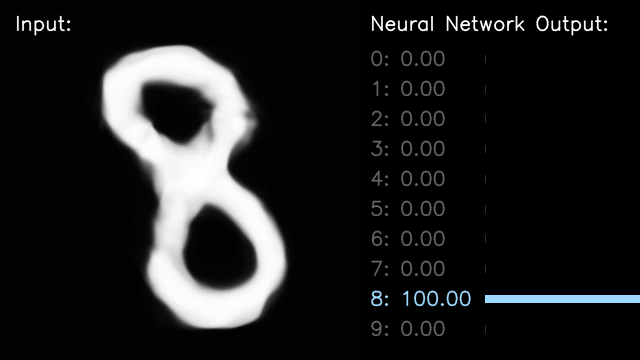

In [ ]:
mnist_dream_path = "../ex3_MLP_MNIST_Keras/mnist_dream.mp4"

def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes() 
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

def drawPrediction(img, y_pred, y_class):
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(y_pred):
        if i == y_class: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 230
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = "%d: %3.2f" % (i, p)
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    return img

cap = cv2.VideoCapture(mnist_dream_path) 
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break
               
    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))
    
    # Pre-process the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = img_proc / 255.
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background
    img_proc = img_proc.reshape((28, 28, 1))
    img_proc = np.expand_dims(img_proc, axis=0)
    
    # Run Prediction
    y_pred = model.predict_proba(img_proc)[0, :]
    y_class = np.argmax(y_pred)
    
    img = drawPrediction(img, y_pred * 100, y_class)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)

cap.release()
if vw is not None:
    vw.release()